In [62]:
import os
from tqdm import tqdm
import numpy as np
import cv2
import torch
from monai.networks.nets import densenet121
from sklearn.preprocessing import normalize
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import umap
import hdbscan
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import numpy as np
import umap
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
device = "cpu"  # CPU is safe and avoids GPU kernel crashes
model = densenet121(spatial_dims=2, in_channels=1, out_channels=1000, pretrained=True)
model.eval()
model.to(device)

def collect_image_paths(root_dir):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                paths.append(os.path.join(root, f))
    return paths

def load_mri_array(path, size=(224,224)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.resize(img, size)
    img = img.astype(np.float32) / 255.0
    return img[None, None, :, :]  # [1,1,H,W]


def edge_orientation_features(img, n_bins=18):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    angles = np.rad2deg(np.arctan2(gy, gx)) % 180.0
    hist, _ = np.histogram(angles, bins=n_bins, range=(0,180), density=True)
    return hist.astype(np.float32)


def extract_features_single(path):
    try:
        img = load_mri_array(path)[0,0]  # shape (H,W)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

    # RadImageNet embedding
    tensor = torch.from_numpy(img[None, None, :, :]).to(device)
    with torch.no_grad():
        emb = model(tensor).cpu().numpy().reshape(-1)

    # Edge histogram
    edge_hist = edge_orientation_features(img)

    return emb, edge_hist, path


def extract_features(images, max_workers=4):
    """
    Extracts RadImageNet + edge features for all images.
    - images: list of paths
    - max_workers: number of threads for edge histogram computation
    """
    rad_embeddings = []
    edge_feats = []
    good_paths = []

    # Sequential loop with optional ThreadPool for edge computation
    def process_image(path):
        result = extract_features_single(path)
        return result

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_image, p) for p in images]
        for f in tqdm(futures, desc="Extracting features"):
            res = f.result()
            if res is not None:
                emb, edge_hist, path = res
                rad_embeddings.append(emb)
                edge_feats.append(edge_hist)
                good_paths.append(path)

    # Stack arrays
    rad_embeddings = np.vstack(rad_embeddings)
    edge_feats = np.vstack(edge_feats)

    # L2-normalize separately then concatenate
    rad_norm = normalize(rad_embeddings, norm="l2")
    edge_norm = normalize(edge_feats, norm="l2")
    full_features = np.hstack([rad_norm, edge_norm])

    return full_features, rad_norm, edge_norm, good_paths


def collect_image_paths(root_dir):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                paths.append(os.path.join(root, f))
    return paths

In [7]:
train_path = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Training"
test_path  = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Testing"

all_paths = collect_image_paths(train_path) 


In [8]:
full_features, rad_embeddings, edge_features, paths = extract_features(all_paths, max_workers=4)
print("full_features shape:", full_features.shape)



OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
Extracting features: 100%|██████████| 5521/5521 [09:03<00:00, 10.15it/s]


full_features shape: (5521, 1018)


In [10]:

def random_search_umap_hdbscan(
    X,
    n_iter=20,               # number of random combinations to try
    random_state=42
):
    random.seed(random_state)
    np.random.seed(random_state)

    best_result = {
        "silhouette": -1,
        "calinski": -1,
        "labels": None,
        "umap_params": None,
        "hdbscan_params": None
    }

    for i in range(n_iter):
        
        # --- Random UMAP Params ---
        umap_params = {
            "n_neighbors": random.choice([5, 10, 15, 20, 30]),
            "min_dist": random.uniform(0.0, 0.99),
            "n_components": random.choice([5, 10, 15]),
            "metric": random.choice(["euclidean", "manhattan", "cosine"])
        }

        # Fit UMAP
        umap_model = umap.UMAP(
            n_neighbors=umap_params["n_neighbors"],
            min_dist=umap_params["min_dist"],
            n_components=umap_params["n_components"],
            metric=umap_params["metric"],
            random_state=random_state,
        )

        embedding = umap_model.fit_transform(X)

        # --- Random HDBSCAN Params ---
        hdbscan_params = {
            "min_cluster_size": random.choice([50, 100, 200, 300]),
            "min_samples": random.choice([1, 5, 10]),
            "metric": random.choice(["euclidean", "manhattan", "chebyshev"])
        }

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=hdbscan_params["min_cluster_size"],
            min_samples=hdbscan_params["min_samples"],
            metric=hdbscan_params["metric"]
        )

        labels = clusterer.fit_predict(embedding)

        # Skip if all noise or only 1 cluster
        if len(set(labels)) <= 1:
            continue

        # Compute metrics
        try:
            sil = silhouette_score(embedding, labels)
        except:
            sil = -1

        try:
            cal = calinski_harabasz_score(embedding, labels)
        except:
            cal = -1

        print(f"Iter {i+1}/{n_iter}")
        print("  Silhouette:", round(sil, 4))
        print("  Calinski:", round(cal, 2))
        print("  UMAP:", umap_params)
        print("  HDBSCAN:", hdbscan_params)
        print("---------------------------")

        # Combine both metrics (you can weight differently)
        score = sil + (cal / 10000)

        # Update best result
        if score > (best_result["silhouette"] + best_result["calinski"] / 10000):
            best_result.update({
                "silhouette": sil,
                "calinski": cal,
                "labels": labels,
                "umap_params": umap_params,
                "hdbscan_params": hdbscan_params
            })

    return best_result


In [11]:
results = random_search_umap_hdbscan(full_features, n_iter=20)

print("Best Silhouette:", results["silhouette"])
print("Best Calinski:", results["calinski"])
print("Best UMAP Params:", results["umap_params"])
print("Best HDBSCAN Params:", results["hdbscan_params"])

best_labels = results["labels"]

/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 1/20
  Silhouette: 0.5332
  Calinski: 1609.06
  UMAP: {'n_neighbors': 5, 'min_dist': 0.024760647670440266, 'n_components': 10, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 1, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 2/20
  Silhouette: 0.1552
  Calinski: 808.54
  UMAP: {'n_neighbors': 5, 'min_dist': 0.6699324925486821, 'n_components': 15, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 3/20
  Silhouette: 0.4694
  Calinski: 1369.69
  UMAP: {'n_neighbors': 5, 'min_dist': 0.21645159505556733, 'n_components': 15, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 50, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 4/20
  Silhouette: 0.3232
  Calinski: 3233.94
  UMAP: {'n_neighbors': 30, 'min_dist': 0.4153246227520421, 'n_components': 10, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 5/20
  Silhouette: 0.4813
  Calinski: 6168.04
  UMAP: {'n_neighbors': 20, 'min_dist': 0.33684801135281195, 'n_components': 5, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 6/20
  Silhouette: 0.5476
  Calinski: 10600.31
  UMAP: {'n_neighbors': 20, 'min_dist': 0.09574921306512937, 'n_components': 10, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 7/20
  Silhouette: 0.2845
  Calinski: 2360.64
  UMAP: {'n_neighbors': 20, 'min_dist': 0.5308658105401537, 'n_components': 10, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 10, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 8/20
  Silhouette: 0.2198
  Calinski: 1133.97
  UMAP: {'n_neighbors': 15, 'min_dist': 0.5715786238041944, 'n_components': 15, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 50, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 9/20
  Silhouette: -0.004
  Calinski: 414.51
  UMAP: {'n_neighbors': 15, 'min_dist': 0.9753693054541501, 'n_components': 5, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 5, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 10/20
  Silhouette: 0.5627
  Calinski: 5962.82
  UMAP: {'n_neighbors': 15, 'min_dist': 0.16102755618452397, 'n_components': 10, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 10, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 11/20
  Silhouette: 0.2147
  Calinski: 791.19
  UMAP: {'n_neighbors': 5, 'min_dist': 0.6030396956103183, 'n_components': 5, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 1, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 12/20
  Silhouette: 0.5025
  Calinski: 5172.86
  UMAP: {'n_neighbors': 20, 'min_dist': 0.2672483485164352, 'n_components': 15, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 10, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 13/20
  Silhouette: 0.501
  Calinski: 1992.58
  UMAP: {'n_neighbors': 5, 'min_dist': 0.22675759124446332, 'n_components': 5, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 5, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 14/20
  Silhouette: 0.2114
  Calinski: 1342.52
  UMAP: {'n_neighbors': 10, 'min_dist': 0.9040047629436896, 'n_components': 15, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 15/20
  Silhouette: 0.7037
  Calinski: 48578.71
  UMAP: {'n_neighbors': 20, 'min_dist': 0.3916755820500576, 'n_components': 15, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 5, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 16/20
  Silhouette: 0.1969
  Calinski: 1774.88
  UMAP: {'n_neighbors': 10, 'min_dist': 0.7375390922706905, 'n_components': 15, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 10, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 17/20
  Silhouette: 0.5477
  Calinski: 6202.5
  UMAP: {'n_neighbors': 15, 'min_dist': 0.21712755156571048, 'n_components': 5, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 18/20
  Silhouette: 0.4273
  Calinski: 1560.16
  UMAP: {'n_neighbors': 5, 'min_dist': 0.15131290615477844, 'n_components': 5, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 19/20
  Silhouette: 0.3067
  Calinski: 3553.05
  UMAP: {'n_neighbors': 20, 'min_dist': 0.3778030936414714, 'n_components': 10, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 20/20
  Silhouette: 0.2038
  Calinski: 608.34
  UMAP: {'n_neighbors': 5, 'min_dist': 0.674893265336309, 'n_components': 15, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'manhattan'}
---------------------------
Best Silhouette: 0.7036837935447693
Best Calinski: 48578.71498460905
Best UMAP Params: {'n_neighbors': 20, 'min_dist': 0.3916755820500576, 'n_components': 15, 'metric': 'manhattan'}
Best HDBSCAN Params: {'min_cluster_size': 100, 'min_samples': 5, 'metric': 'euclidean'}


In [22]:
n_clusters = len(set(best_labels) - {-1})
n_noise = np.sum(best_labels == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 3
Noise points: 0


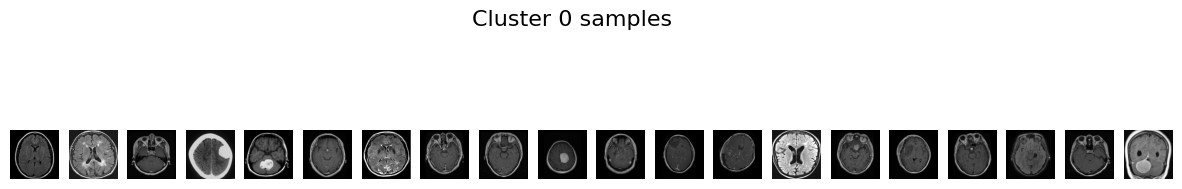

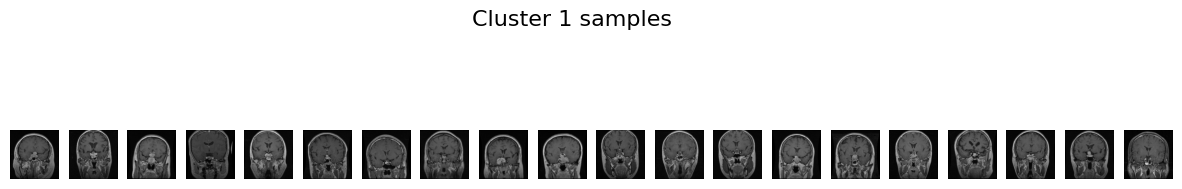

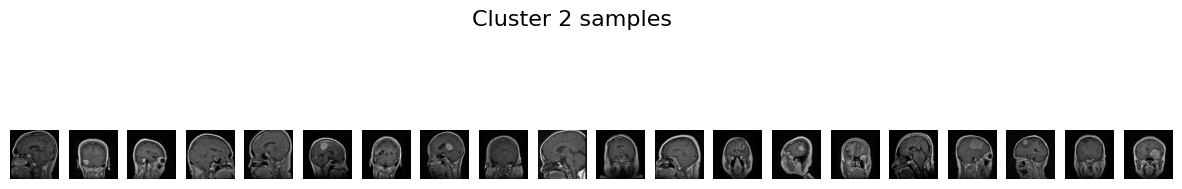

In [59]:

def sample_images_per_cluster(paths, labels, n_samples=5):
    """
    Randomly sample n_samples images per cluster.
    
    Args:
        paths (list): list of image paths
        labels (array): cluster labels from HDBSCAN
        n_samples (int): number of images to sample per cluster
    """
    from collections import defaultdict
    
    # Group paths by cluster
    cluster_dict = defaultdict(list)
    for path, label in zip(paths, labels):
        if label != -1:  # ignore noise points
            cluster_dict[label].append(path)
    
    # Sample images per cluster
    sampled_images = {}
    for cluster, images in cluster_dict.items():
        if len(images) < n_samples:
            sampled_images[cluster] = images
        else:
            sampled_images[cluster] = random.sample(images, n_samples)
    
    return sampled_images, cluster_dict

# ---- Example usage ----
sampled, cluster_dict = sample_images_per_cluster(paths, best_labels, n_samples=20)

# ---- Plot sampled images per cluster ----
for cluster, imgs in sampled.items():
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Cluster {cluster} samples", fontsize=16)
    for i, img_path in enumerate(imgs):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()


Best Silhouette: 0.7036837935447693
Best Calinski: 48578.71498460905
Best UMAP Params: {'n_neighbors': 20, 'min_dist': 0.3916755820500576, 'n_components': 15, 'metric': 'manhattan'}
Best HDBSCAN Params: {'min_cluster_size': 100, 'min_samples': 5, 'metric': 'euclidean'}

/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


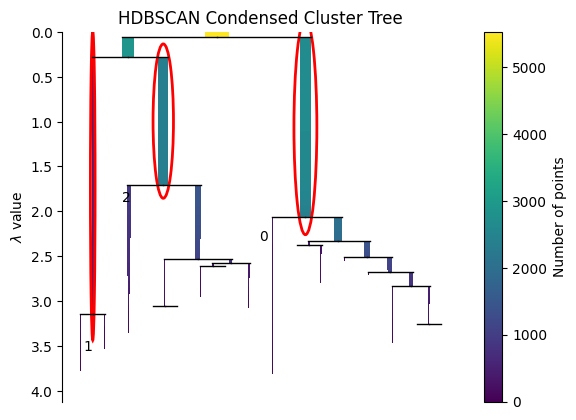

In [47]:

umap_model = umap.UMAP(
            n_neighbors=20,
            min_dist=0.3916755820500576,
            n_components=15,
            metric='manhattan',
            random_state=42,
        )

embedding = umap_model.fit_transform(full_features)

# Assuming your HDBSCAN model is already fit
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=5,
    metric='euclidean',
    prediction_data=True
)

labels = clusterer.fit_predict(embedding)

clusterer.condensed_tree_.plot(
    select_clusters=True,
    label_clusters=True
)
plt.title("HDBSCAN Condensed Cluster Tree")
plt.show()


In [48]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter

def grad_cam(
    model, 
    input_tensor, 
    target_neuron=None, 
    target_layer=None, 
    pool_type='mean',   # 'mean' or 'max'
    use_relu=True, 
    smooth_sigma=0.0,   # sigma for optional Gaussian smoothing
    upsample_method='bilinear'
):
    """
    Compute Grad-CAM for a single image.
    
    Args:
        model: PyTorch model
        input_tensor: Tensor (1,C,H,W)
        target_neuron: int or None, which neuron in the output to visualize
        target_layer: nn.Module or None, which conv layer to use (default last Conv2d)
        pool_type: 'mean' or 'max' for gradient pooling
        use_relu: bool, whether to apply ReLU to CAM
        smooth_sigma: float, sigma for Gaussian smoothing
        upsample_method: 'bilinear' or 'nearest'
    
    Returns:
        heatmap: numpy array (H,W) in [0,1]
    """
    activations = None
    gradients = None

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # If target layer not specified, use last Conv2d
    if target_layer is None:
        for name, m in reversed(list(model.named_modules())):
            if isinstance(m, torch.nn.Conv2d):
                target_layer = m
                break
        if target_layer is None:
            raise ValueError("No Conv2d layer found")

    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_backward_hook(backward_hook)

    model.eval()
    model.zero_grad()

    output = model(input_tensor)
    if target_neuron is None:
        target_neuron = output.argmax().item()
    target = output[0, target_neuron]
    target.backward()

    # Gradient pooling
    if pool_type == 'mean':
        weights = gradients.mean(dim=(2,3), keepdim=True)
    elif pool_type == 'max':
        weights = gradients.max(dim=(2,3), keepdim=True)[0]
    else:
        raise ValueError("pool_type must be 'mean' or 'max'")

    cam = (weights * activations).sum(dim=1, keepdim=True)
    if use_relu:
        cam = F.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()

    # Optional Gaussian smoothing
    if smooth_sigma > 0:
        cam = gaussian_filter(cam, sigma=smooth_sigma)

    # Resize to input size
    H, W = input_tensor.shape[2], input_tensor.shape[3]
    if upsample_method == 'bilinear':
        cam = cv2.resize(cam, (W,H), interpolation=cv2.INTER_LINEAR)
    elif upsample_method == 'nearest':
        cam = cv2.resize(cam, (W,H), interpolation=cv2.INTER_NEAREST)
    else:
        raise ValueError("upsample_method must be 'bilinear' or 'nearest'")

    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Remove hooks
    h1.remove()
    h2.remove()

    return cam


In [49]:
def overlay_heatmap(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlay Grad-CAM heatmap on grayscale image
    """
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), colormap)
    img_color = cv2.cvtColor(np.uint8(img*255), cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(img_color, 1-alpha, heatmap_color, alpha, 0)
    return overlay


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


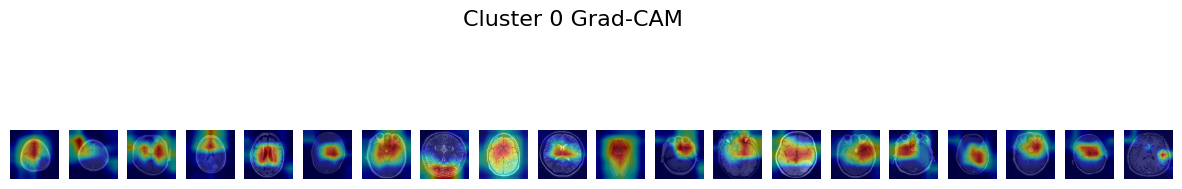

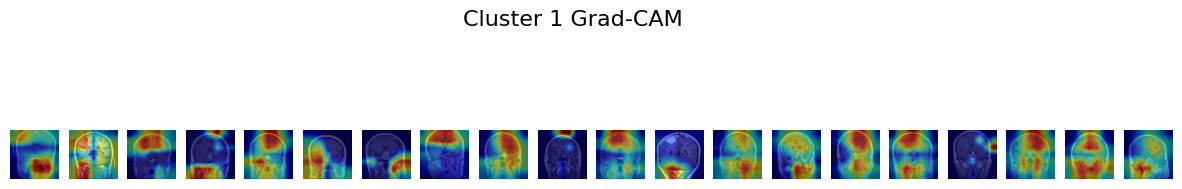

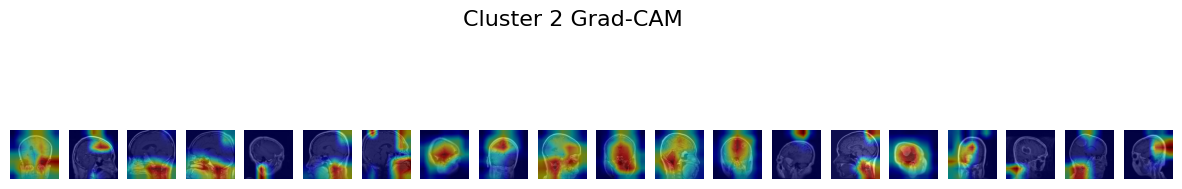

In [50]:
# Suppose you already have 'sampled' dict: cluster -> list of paths
for cluster, imgs in sampled.items():
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Cluster {cluster} Grad-CAM", fontsize=16)
    
    for i, img_path in enumerate(imgs):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
        input_tensor = torch.from_numpy(img[None, None, :, :]).to(device)
        
        cam = grad_cam(model, input_tensor)  # compute Grad-CAM
        overlay = overlay_heatmap(img, cam)
        
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(overlay[..., ::-1])  # convert BGR -> RGB
        plt.axis("off")
    
    plt.show()


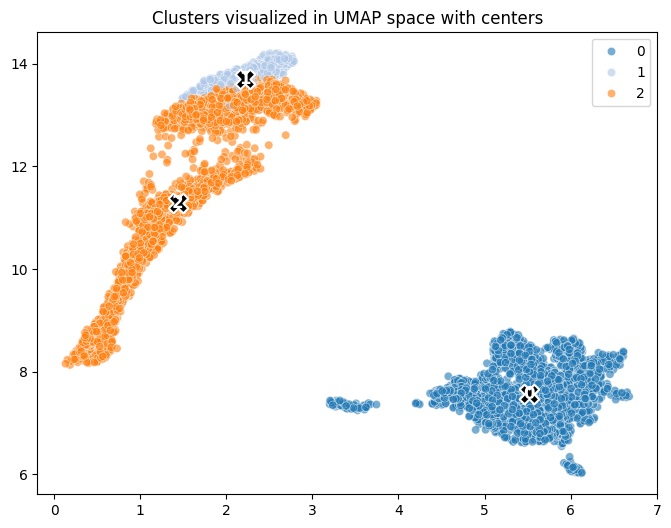

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8,6))

# Scatter plot of points
sns.scatterplot(
    x=embedding[:,0], 
    y=embedding[:,1], 
    hue=labels, 
    palette="tab20", 
    legend="full",
    alpha=0.6  # semi-transparent
)

# Compute and plot cluster centers
for lbl in np.unique(labels):
    x_mean = embedding[labels==lbl, 0].mean()
    y_mean = embedding[labels==lbl, 1].mean()
    plt.scatter(
        x_mean, y_mean, 
        s=200,           # bigger marker for center
        color='black',   # black for contrast
        marker='X',      # cross marker
        edgecolor='white',
        linewidth=1.5,
        zorder=5         # on top of scatter points
    )
    plt.text(x_mean, y_mean, str(lbl), fontsize=12, fontweight='bold',
             color='white', ha='center', va='center', zorder=6)

plt.title("Clusters visualized in UMAP space with centers")
plt.show()





In [42]:
test_path  = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Testing"
test_paths = collect_image_paths(test_path) 

In [44]:
full_features_test, rad_embeddings_test, edge_features_test, paths_test = extract_features(test_paths, max_workers=4)
print("full_features shape:", full_features_test.shape)

Extracting features: 100%|██████████| 1205/1205 [01:37<00:00, 12.31it/s]

full_features shape: (1205, 1018)


In [52]:
# Transform test set using the trained UMAP
test_embedding = umap_model.transform(full_features_test)

# Predict test clusters with approximate_predict
from hdbscan import approximate_predict
test_labels, test_probs = approximate_predict(clusterer, test_embedding)


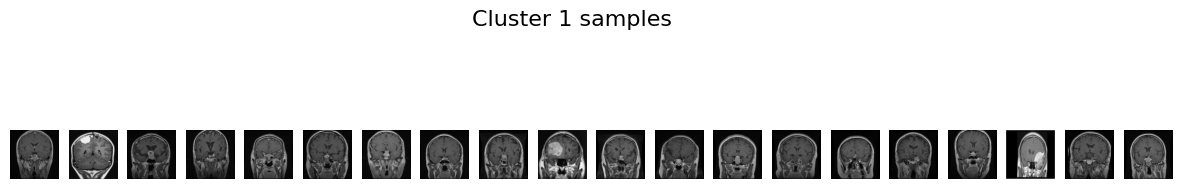

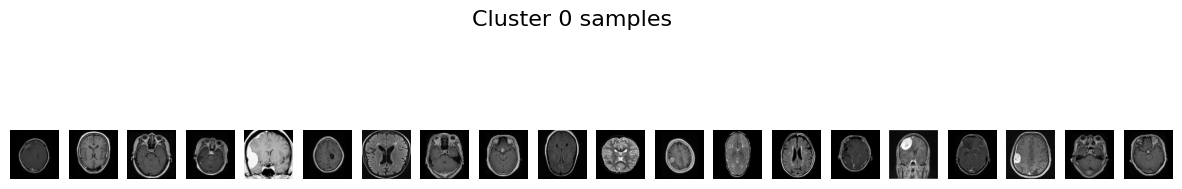

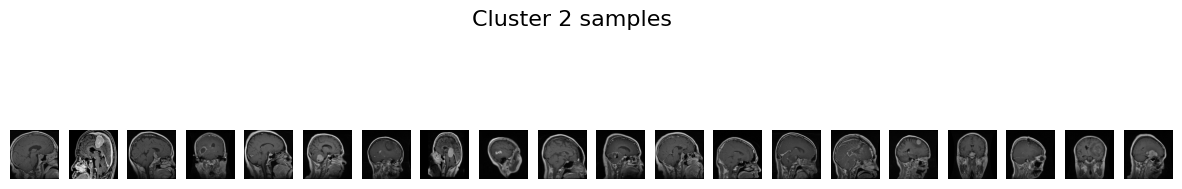

In [66]:
sampled, test_cluster_dict = sample_images_per_cluster(test_paths, test_labels, n_samples=20)

# ---- Plot sampled images per cluster ----
for cluster, imgs in sampled.items():
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Cluster {cluster} samples", fontsize=16)
    for i, img_path in enumerate(imgs):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

Overall we observe a good test performance! 

In [67]:
sil_score = silhouette_score(test_embedding, test_labels)
print("Silhouette score:", sil_score)

# Calinski-Harabasz index
ch_score = calinski_harabasz_score(test_embedding, test_labels)
print("Calinski-Harabasz index:", ch_score)

Silhouette score: 0.7242381572723389
Calinski-Harabasz index: 10510.307821771465


(this is the train performance as a reminder)

In [68]:
sil_score = silhouette_score(embedding, labels)
print("Silhouette score:", sil_score)

# Calinski-Harabasz index
ch_score = calinski_harabasz_score(embedding, labels)
print("Calinski-Harabasz index:", ch_score)

Silhouette score: 0.7036837935447693
Calinski-Harabasz index: 48578.71498460905


In [69]:
data = []
for cluster_label, paths in cluster_dict.items():
    for path in paths:
        # Extract folder name just before the filename
        tumor_type = os.path.basename(os.path.dirname(path))
        data.append((cluster_label, tumor_type))

# Put into a DataFrame
df = pd.DataFrame(data, columns=['cluster', 'tumor_type'])
cluster_counts = df.groupby(['cluster', 'tumor_type']).size().unstack(fill_value=0)
print(cluster_counts)

tumor_type  glioma  meningioma  notumor  pituitary
cluster                                           
0              480         432     1299        424
1                1          43        9        485
2              840         858      114        536


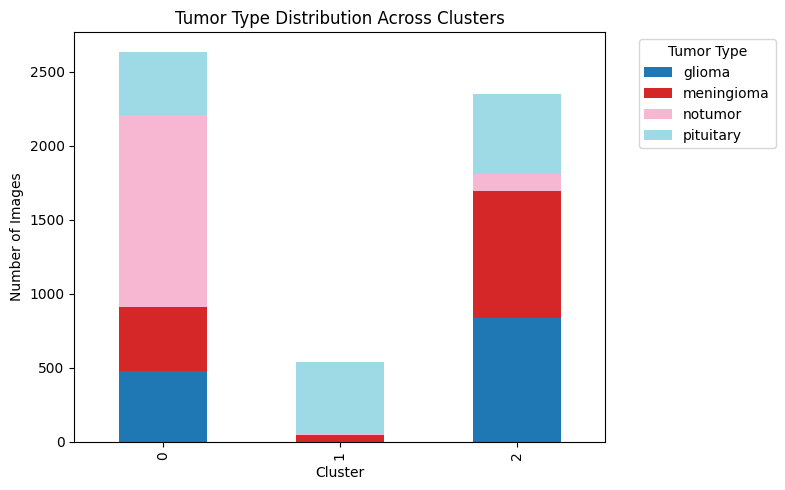

In [70]:
cluster_counts.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,5))
plt.title("Tumor Type Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
